# project overview

Previously,  people are confused about switching to solar power or not because of misinformations related to:


    How much electricity do solar panels produce in a year where I live?
    What would be my solar savings and payback from a solar installation ?
    
To answer to these questions, companies will give you the answers but you have to pay them for the information. This cost prevents people from purchasing solar panels for their homes.

Our goal with this project is to make available information for consumers to make their own decisions about buying solar panels for free. Basically, the idea is to help people to know how much solar energy they will get, and what would be their solar savings
from electricity bills every year according to the size of a future solar panel installation  as well as other parameters related to sun position, and the panels’ location on the earth.

We accomplished this goal in two stages:                  
 1/ Building a machine learning model that predicts the annual energy            production of a solar installation.              
 2/ then deploy these on a web app that shows users how much money they should expect to save by switching to solar.


In [1]:
import graphviz 
import numpy as np
import pandas as pd
from datetime import datetime
import dateutil.parser
import re


# Packages for checking assumptions
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.set()
sns.set(font_scale=1.5)

# Packages for checking assumptions
from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
import statsmodels.formula.api as sm

# Set jupyter notebook preferences
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

sns.set_palette("hls")
%matplotlib inline

In [3]:
df=pd.read_csv('solar_energie_data.csv')

C:\Users\mohamed\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,5,8,12,13,14,15,16,20,23,25,26,27,28,32,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head(3)

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,cost,lbnl_tts_version_year,lbnl_tts,city,utility_clean,tech_1,model1_clean,county,annual_PV_prod,annual_insolation,rebate,sales_tax_cost,tilt1,tracking_type,azimuth1,manuf2_clean,manuf3_clean,manuf1_clean,inv_man_clean,reported_annual_energy_prod,incentivetype,year_app_implied,year,npv_fit_real,application_implied,npv_pbi_real,other_incentive,appraised_cluster,inflation,other_incentive_real,zip_available,cust_city,pbi,pbi_real,pbi_length,application,fit_length,fit_rate,fit_payment,_3rdparty_implied,utility,install_price_real_w,install_price,installer_clean,manuf1_,inverter_reported,rebate_real,model1,_3rdparty,inv_model_reported,microinv_solarhub,bipv_3,bipv_2,bipv_1,sales_tax_rate,sales_tax_cost_real,bipv_all,thinfilm_all,china,sys_sizeac,pbi_rate,new_constr,effic_1,cust_county,tracking,inv_model_clean,mod_cost_real,inv_cost_real,bos_powerclerk_real,permitting_real,3rdparty
0,TX,12/12/2013,Austin Energy,uir,10.56,NaN,78702.0,residential,NaN,2.897777,30600.53,2016.0,True,AUSTIN,Austin Energy,Poly,CHSM6610P-240,Travis,14999.831600,5.157692,15000,1151.693704,10.0,Fixed,180.0,Chint Solar (Zhejiang),Chint Solar (Zhejiang),Chint Solar (Zhejiang),NaN,13836.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TX,07/11/2014,Austin Energy,uir,12.72,NaN,78702.0,residential,NaN,3.144654,40000.00,2016.0,True,AUSTIN,Austin Energy,Mono,SLA265M3A,Travis,17811.574390,5.085633,15000,1507.165990,7.0,Fixed,180.0,NaN,NaN,NaN,NaN,16419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TX,01/17/2014,Austin Energy,uir,5.40,NaN,78702.0,residential,NaN,4.197330,22665.58,2016.0,True,AUSTIN,Austin Energy,Mono,PLM-300M-72,Travis,7833.742822,5.262714,7735.5,854.019783,18.5,Fixed,165.0,NaN,NaN,NaN,NaN,7235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


let's take variables we want to work with to a new dataframe

In [7]:
df1=df[['size_kw','cost_per_watt','cost','annual_PV_prod','annual_insolation',
        'sales_tax_cost','reported_annual_energy_prod','tilt1','azimuth1',
        'install_type','tracking_type','zipcode','state']]

# Data Cleaning

In [10]:
#let's look at empty values
df1.isnull().sum()

size_kw                             5
cost_per_watt                  257584
cost                           257423
annual_PV_prod                 239844
annual_insolation              239844
sales_tax_cost                 665504
reported_annual_energy_prod    816384
tilt1                          637448
azimuth1                       657532
install_type                    42581
tracking_type                  494755
zipcode                             5
state                               0
dtype: int64

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020813 entries, 0 to 1020812
Data columns (total 13 columns):
size_kw                        1020808 non-null float64
cost_per_watt                  763229 non-null float64
cost                           763390 non-null float64
annual_PV_prod                 780969 non-null float64
annual_insolation              780969 non-null float64
sales_tax_cost                 355309 non-null float64
reported_annual_energy_prod    204429 non-null float64
tilt1                          383365 non-null float64
azimuth1                       363281 non-null float64
install_type                   978232 non-null object
tracking_type                  526058 non-null object
zipcode                        1020808 non-null float64
state                          1020813 non-null object
dtypes: float64(10), object(3)
memory usage: 101.2+ MB


In [14]:
#we can just remove emty values because we still have a large dataset
df1=df1.dropna(axis=0,how='any')

In [15]:
#making sure we still not have empty values
df1.isnull().sum()

size_kw                        0
cost_per_watt                  0
cost                           0
annual_PV_prod                 0
annual_insolation              0
sales_tax_cost                 0
reported_annual_energy_prod    0
tilt1                          0
azimuth1                       0
install_type                   0
tracking_type                  0
zipcode                        0
state                          0
dtype: int64


# Exploratory data analysis

we will use a scatter Matrix to visulise relationships between variables

Scatter Matrix

C:\Users\mohamed\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


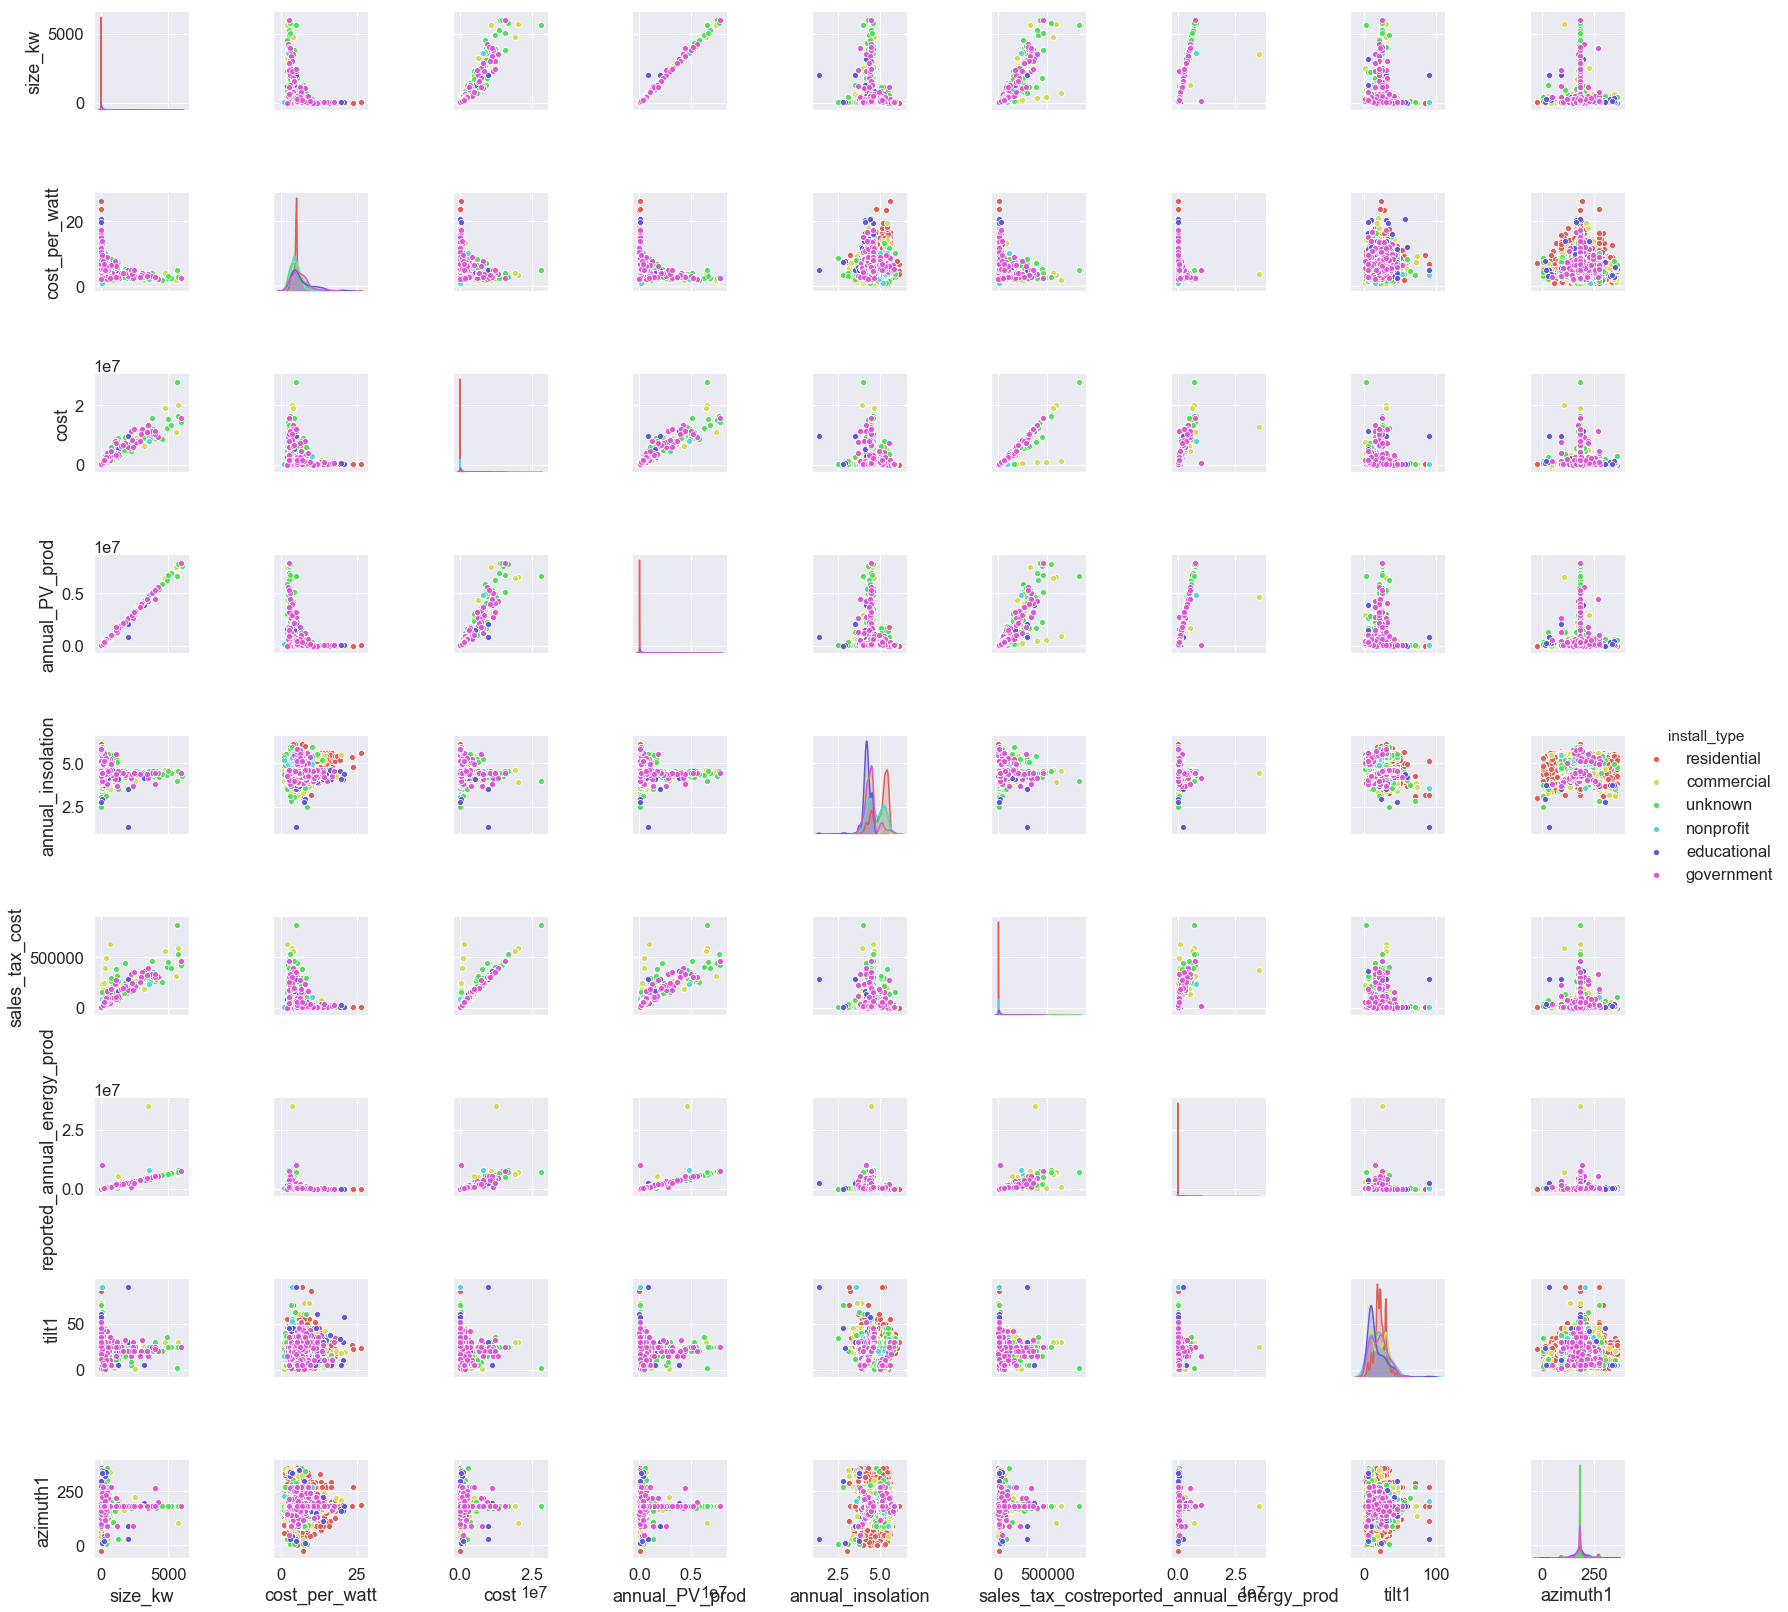

In [17]:
#Create thescatter plot and let's color the data point by their technologie type.
columns = ['size_kw','cost_per_watt','cost','annual_PV_prod', 'annual_insolation',
           'sales_tax_cost','reported_annual_energy_prod', 'tilt1','azimuth1',
           'install_type']
num_df = df1[columns]
sns.pairplot(num_df, hue='install_type');

Let's choose only a couple of columns showed some good interpretations to examine:

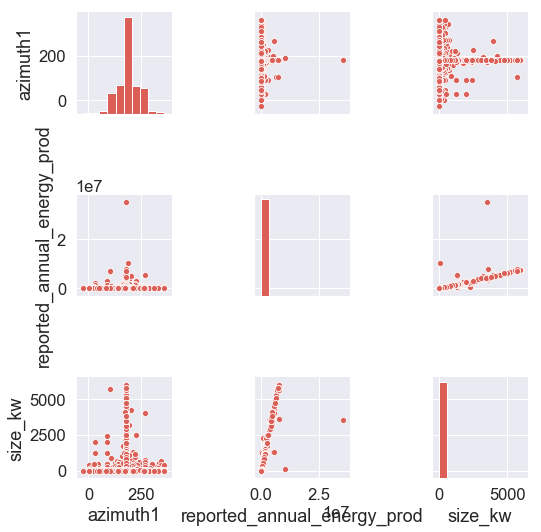

In [18]:

#columns1 = ['size_kw', 'reported_annual_energy_prod','azimuth1','tilt1','install_type']
columns1 = ['azimuth1','reported_annual_energy_prod','size_kw']
num_df1 = df1[columns1]

# Create the scatter plot and let's color the data point by their status.
sns.pairplot(num_df1);

we can notice a strong linear relationship between the size and the annual energy produced

also a special point of azimuth where the energie producted get high values (azimuth =200) 
the azimuth related on a good position where the sun are more exploited in our dataset

# Tilt
it looks like the energy is acheiving high values in a 'champ' of 0 to 50 in tilt .

and that is normal cause almost articles on solar energy often give the advice that the tilt should be equal to your latitude,

plus 15 degrees in winter,
or minus 15 degrees in summer

and the USA titl is between 30 < tilt < 50 wich puting the optimal interval for panels in    15 < tilt < 65
(counting the summer and the winter advices)

and in data the interval tilt geting highest values is  0 <tilt < 50 ( that interval is including in the optiaml one we found)


In [1]:
#Let's look at the global distribution of the predicted size

C:\Users\mohamed\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


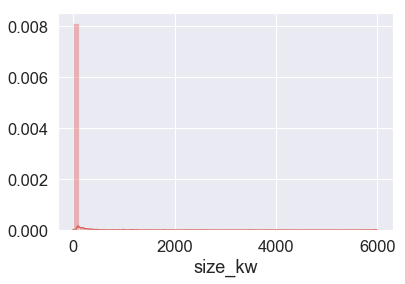

In [19]:
sns.distplot(df1['size_kw']);

C:\Users\mohamed\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


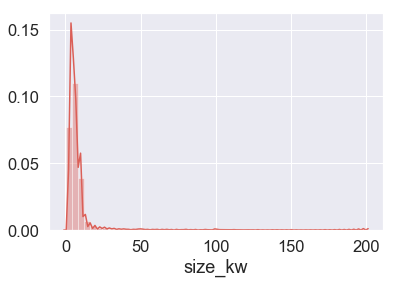

In [20]:
# Let's just look at those under 200Kw
small_sizes_df = df1[(df1['size_kw'] < 200)]
sns.distplot(small_sizes_df['size_kw']);

In [21]:
# Let's start out by looking at the distribution of our target variable (reported annual energy produced)

<Figure size 504x288 with 0 Axes>

C:\Users\mohamed\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


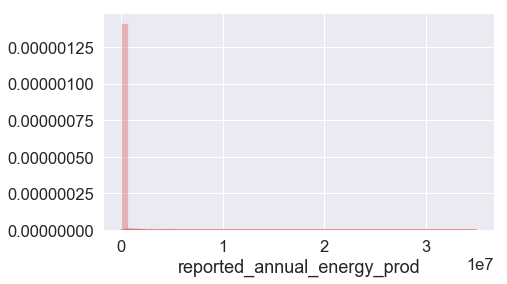

In [23]:
plt.figure(figsize=((7,4)))
sns.distplot(df1.reported_annual_energy_prod)

C:\Users\mohamed\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


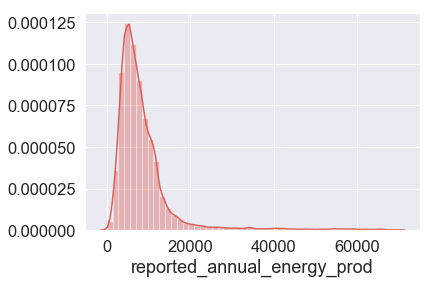

In [24]:
# We can see the skew a little more clearly when we limit the energy production to below 70000 kilowatt hours annually.
small_sizes_df = df1[(df1['reported_annual_energy_prod'] < 70000)]
sns.distplot(small_sizes_df['reported_annual_energy_prod']);

install Type

In [26]:
df1['install_type'].unique()

array(['residential', 'commercial', 'unknown', 'nonprofit', 'educational',
       'government'], dtype=object)

In [28]:
df1 = df1.replace({'unknown': None})

C:\Users\mohamed\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


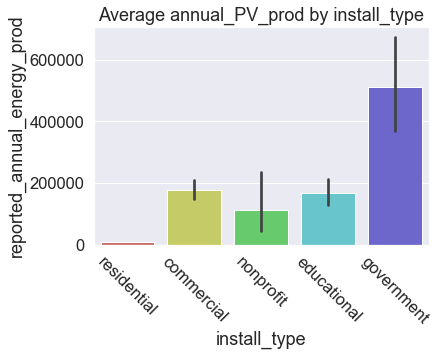

In [33]:
p = sns.barplot(x='install_type', y = 'reported_annual_energy_prod', data=df1, estimator=np.mean);
p.set(title='Average annual_PV_prod by install_type')
p.set_xticklabels(p.get_xticklabels(), rotation=-45);

# Looking at the relationship between size and output

Clearly a very strong linear relationship between size and reported annual energy production

<Figure size 720x504 with 0 Axes>

(-100, 6500)

(-500000, 9000000.0)

Text(0.5,0,'Kilowatt Size Capacity')

Text(0,0.5,'Annual kWh Energy Produced')

Text(0.5,1,'Solar Installations: Size and Annual Energy Produced')

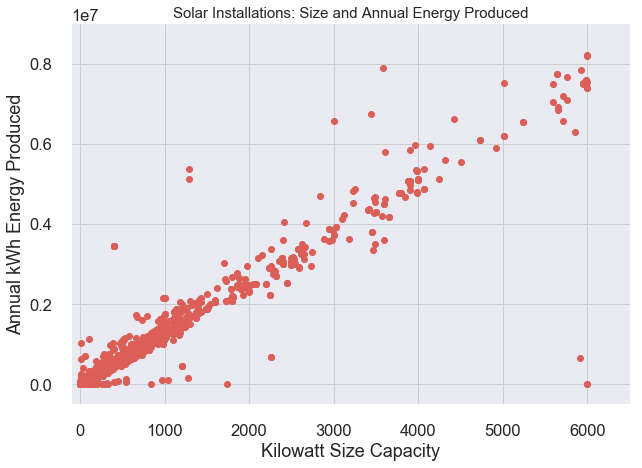

In [34]:
plt.figure(figsize=((10,7)))
plt.scatter(df.size_kw, df.reported_annual_energy_prod)
plt.xlim(-100,6500)
plt.ylim(-500000,.9*10**7)
plt.xlabel("Kilowatt Size Capacity")
plt.ylabel("Annual kWh Energy Produced")
plt.title("Solar Installations: Size and Annual Energy Produced", size=15)
sns.set_style("white")
sns.despine(offset=10, trim=False)

Size is highly correlated with annual energy production. When we look at a scatter plot of size and annual production, 
the linear relationship between the two is clear. The larger an installation, the higher its capacity for transforming 
solar radiation into electricity, and thus the observed relationship.

# build a models Linear Regression

state and install type are categorical variables, we should turn them to int type using dummies technique

In [68]:
state_list=df1['state'].unique()
def data_cleaning(df2):
    df2.loc[df1["install_type"]=="residential","install_type"] = 1
    df2.loc[df1["install_type"]=="Residential","install_type"] = 1
    
    df2.loc[df1["install_type"]=="commercial","install_type"] = 2
    df2.loc[df1["install_type"]=="Commercial","install_type"] = 2
    
    df2.loc[df1["install_type"]=="nonprofit","install_type"] = 3
    df2.loc[df1["install_type"]=="Nonprofit","install_type"] = 3
    
    df2.loc[df1["install_type"]=="educational","install_type"] = 4
    df2.loc[df1["install_type"]=="Educational","install_type"] = 4

    df2.loc[df1["install_type"]=="governement","install_type"] = 5
    df2.loc[df1["install_type"]=="Governement","install_type"] = 5

    i=6
    for state in state_list:
        df2.loc[df2["state"]==state,"state"] =i
        i+=1
    return df2
df1=data_cleaning(df1)       

In [70]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'reported_annual_energy_prod'
y = df1[y_column]
# Define our independent variables
x_columns = ['size_kw','annual_insolation','tilt1','azimuth1','state','zipcode']
X = df1[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['cnst'] = 1
# Split our data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
model = sm.OLS(endog=y_train, exog=X_train).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     reported_annual_energy_prod   R-squared:                       0.715
Model:                                     OLS   Adj. R-squared:                  0.715
Method:                          Least Squares   F-statistic:                 1.228e+04
Date:                         Sat, 24 Nov 2018   Prob (F-statistic):               0.00
Time:                                 19:25:24   Log-Likelihood:            -3.9875e+05
No. Observations:                        29356   AIC:                         7.975e+05
Df Residuals:                            29349   BIC:                         7.976e+05
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

Using the linear regression model, we achieved an R² value of 71 %

drive us to change or strengthening the model

# Random Forest

In [74]:
# Drop everything that is not numeric
df1 = df1.select_dtypes(exclude=['object'])

In [75]:
y_column = 'reported_annual_energy_prod'
y = df1[y_column]
 
X = df1[['size_kw','annual_insolation','tilt1','azimuth1','state','zipcode']]

In [76]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters, print_oob_score=False):
    """A helper function that:
        - Trains a regressor on training data
        - Scores data on training and test data
        - Returns a trained model
    """
    # Step 1: Initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)
    
    # Step 2: Training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    
    # Step 3: Calculating the score of the predictive power on the training and testing dataset.
    training_score = regressor.score(X_train, y_train)
    testing_score = regressor.score(X_test, y_test)
    
    # Print the results!
    print(f"Train score: {training_score:>5.4f}")
    print(f"Test score: {testing_score:>7.4f}")
    if print_oob_score:
        print(f"OOB score: {regressor.oob_score_:>8.4f}")
        
    return regressor

In [77]:
trained_regressor = train_score_regressor(sklearn_regressor=DecisionTreeRegressor,
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          X_test=X_test, 
                                          y_test=y_test, 
                                          model_parameters={'random_state':42})

Train score: 0.8553
Test score:  0.9781


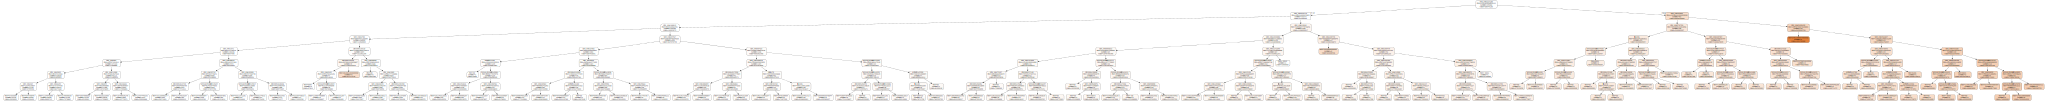

In [85]:
# from the sklearn tree library, create image of trained decision tree
dot_data = tree.export_graphviz(trained_regressor, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=y_train.values,  
                         filled=True, rounded=True,  
                         special_characters=True) 
# use graphviz to render the image
graph = graphviz.Source(dot_data) 
graph

Random forest models also do well with categorical features, and in this case there were a few such features, 
random forest model are a clear and easy way to interpret how much different variables contribute to predictions
produce more energy

We will go to visualise how R^2 look in a scattor plot.

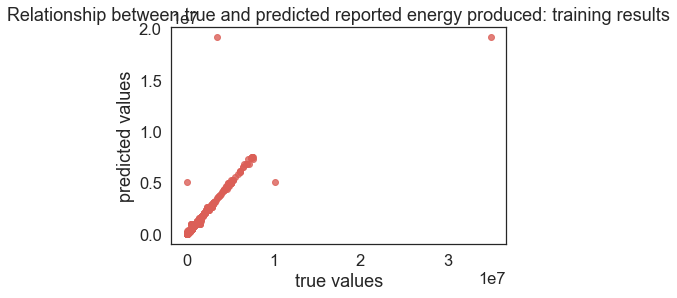

In [93]:
# plotting a graph of the true values vs the predicted values for the training and test datasets
def plot_y_yhat_scatter(y_actual,y_predicted,train_test):
    ax = sns.regplot(x=y_actual, y=y_predicted, fit_reg=False)
    ax.set_xlabel('true values')
    ax.set_ylabel('predicted values')
    ax.set_title('Relationship between true and predicted reported energy produced: '+train_test+' results')
    pass


plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test = "training")

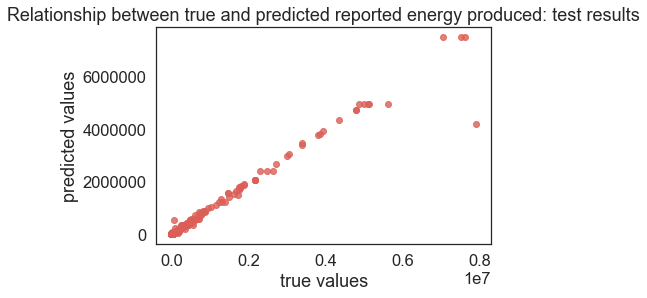

In [94]:
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test = "test")

# feature importants 

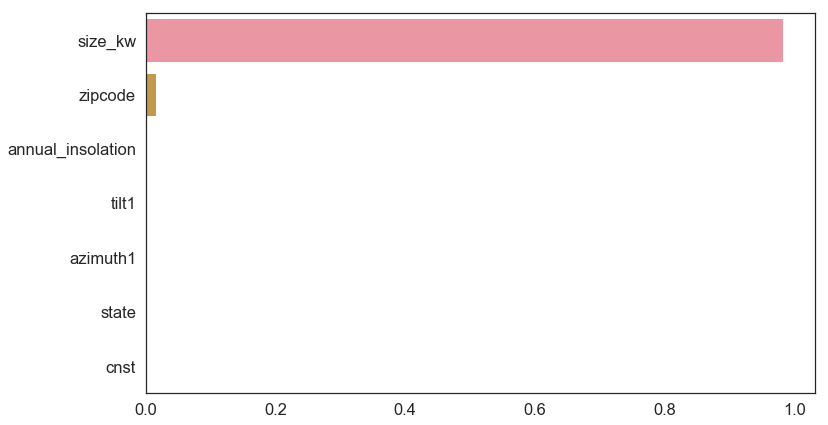

In [86]:
# Get the feature importances from our final trained model...
importances = trained_regressor.feature_importances_

# Find the indices of the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plotting a bar chart of feature importances in descending order
plt.figure(figsize=(12,7))
sns.barplot(y=X_train.columns[indices],x=importances[indices]);

We see that size contributes the most to predicting energy production, with an 87% importance.
These findings indicate that while it’s most important to build as large an installation as possible
The more off a solar panel is from its optimal tilt, the less energy it will generate. Other factors in the model have a negligible importance.


# Modeling Annual Energy Output

The final model we used for production was a random forest regression model, which has several benefits in this context (comparing hes performance against Linear Regression)

# Features
Based on our exploratory analysis, I settled on the following features for my model: Kilowatt Size/Capacity Azimuth Tilt Technology type Tracking type

In [ ]:
# Calculating median dollars estimate is off in annual returns on solar energy generated.

abs_residuals = np.abs(np.array(nrel_y_true) - np.array(rf_pred))

# avg us rate per kilowatt hour is $.1024
residuals_dollars = abs_residuals * .1024

np.median(residuals_dollars)